# IRDM: Assignment 4-5

# Team members: 
### Merey Orazaly, Akzhurek Askarbek, Bekdaulet Magadanov, Olzhas Uikas, Arsen Amanzholov

# Group: BD-2006


### Assignment (part 1, Unsupervised, 25%):
1. Explore the dataset. Do the descriptive statistics.
2. Explanatory data analysis. Exploring the features, visualizations etc. (https://
www.kaggle.com/learn/data-visualization, https://towardsdatascience.com/ exploratory-data-analysis-8fc1cb20fd15, https://www.mastersindatascience.org/ learning/what-is-exploratory-data-analysis/ )
3. Feature engineering. Encodings, generating the features from date-time, sum and from other columns. (https://www.kaggle.com/learn/feature-engineering, https:// www.kaggle.com/learn/data-cleaning )
4. Unsupervised learning. Do the Cluster analysis. Segment the customers. K-means, Hierarchical Clustering. With different metrics, linkages. Visualize the clusters etc. Look for the optimal number of the clusters
5. Analyzing the results.
6. Conclusion.

**Dataset Description:**
- types.csv - reference of transaction types
- codes.csv - reference of transaction codes
- transactions.csv - transactional data on banking operations
- train_set.csv - training set with client gender marking (0/1 - client gender) 
- test_set.csv - no need to use.

**Transactions.csv columns description:**
- client_id - client is id
- datetime -transaction date (format - ordered day number hh:mm:ss - 421 06:33:15) - code - transaction code
- type - transaction type
- sum - sum of transaction

In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

## 1. Explore the dataset. Do the descriptive statistics.

In [2]:
#Load and observe datasets
transactions = pd.read_csv('transactions.csv', sep=';')
transactions.head()

,client_id,datetime,code,type,sum
0,96372458,421 06:33:15,6011,2010,-561478.94
1,24567813,377 17:20:40,6011,7010,67377.47
2,21717441,55 13:38:47,6011,2010,-44918.32
3,14331004,263 12:57:08,6011,2010,-3368873.66
4,85302434,151 10:34:12,4814,1030,-3368.87


In [3]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130039 entries, 0 to 130038
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   client_id  130039 non-null  int64  
 1   datetime   130039 non-null  object 
 2   code       130039 non-null  int64  
 3   type       130039 non-null  int64  
 4   sum        130039 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.0+ MB


In [4]:
codes = pd.read_csv('codes.csv', sep=";")
codes.head()

,code,code_description
0,5944,"Магазины по продаже часов, ювелирных изделий и..."
1,5621,Готовые сумочные изделия
2,5697,"Услуги по переделке, починке и пошиву одежды"
3,7995,Транзакции по азартным играм
4,5137,"Мужская, женская и детская спец-одежда"


In [5]:
codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   code              184 non-null    int64 
 1   code_description  184 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [6]:
types = pd.read_csv('types.csv', sep=';')
types.head()

,type,type_description
0,8001,Установление расх. лимита по карте
1,2411,Перевод с карты на счет др.лица в одном тер. б...
2,4035,н/д(нет данных)
3,3001,Комиссия за обслуживание ссудного счета
4,2420,Перевод с карты на счет физ.лица в другом тер....


In [7]:
types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   type              155 non-null    int64 
 1   type_description  155 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [8]:
train = pd.read_csv('train_set.csv', sep=';')
train.head()

,client_id,target
0,75063019,0
1,86227647,1
2,6506523,0
3,50615998,0
4,95213230,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  6000 non-null   int64
 1   target     6000 non-null   int64
dtypes: int64(2)
memory usage: 93.9 KB


In [10]:
# number of clients
print("Number of clients:", transactions.client_id.nunique())

Number of clients: 8656


In [11]:
# number of completed transactions
print("Number of completed transactions:",transactions.code.nunique())

Number of completed transactions: 175


In [12]:
# Combine all datasets into one df
t1 = transactions.merge(train, how='left', on='client_id').copy()
t2 = t1.merge(types, how='left', on='type').copy()
transaction = t2.merge(codes, how='left', on='code').copy() 
transaction.head()

,client_id,datetime,code,type,sum,target,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,24567813,377 17:20:40,6011,7010,67377.47,NaN,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
2,21717441,55 13:38:47,6011,2010,-44918.32,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,14331004,263 12:57:08,6011,2010,-3368873.66,NaN,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,85302434,151 10:34:12,4814,1030,-3368.87,0.0,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих..."


In [14]:
# The shape of transaction table
transaction.shape

(130039, 8)

**Comment: There are data about 130.039 transactions that were done in bank with different information such as client id, datetime, sum, gender (target) and others.**

In [15]:
# Drop the rows where we have no data (н/д - нет данных)
print("The number of 'н/д' rows:", len(transaction[transaction.type_description == 'н/д']))
transaction.drop(transaction[transaction.type_description == 'н/д'].index, inplace=True)

transaction.shape

The number of 'н/д' rows: 122


(129917, 8)

In [17]:
# fill NaN values in the target column
# first we sort the column, then we fill in the nulls with the values of the previous row
transaction.target = transaction.sort_values(by='client_id').target.fillna(method='ffill')

In [18]:
transaction.head()

,client_id,datetime,code,type,sum,target,type_description,code_description
0,96372458,421 06:33:15,6011,2010,-561478.94,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
1,24567813,377 17:20:40,6011,7010,67377.47,1.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...
2,21717441,55 13:38:47,6011,2010,-44918.32,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
3,14331004,263 12:57:08,6011,2010,-3368873.66,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...
4,85302434,151 10:34:12,4814,1030,-3368.87,0.0,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих..."


In [19]:
#separating a sequence of days from the datetime column
days_hour = [i for i in transaction.datetime.str.split(' ')]
days = [days_hour[i][0] for i in range(len(days_hour))]
days = [int(i) for i in days]

In [97]:
#creation a real date with corresponding days
year_w_d = pd.date_range(end = '2021-01-01', periods = max(days)+1).tolist()
year_w_d

[Timestamp('2019-10-03 00:00:00', freq='D'),
 Timestamp('2019-10-04 00:00:00', freq='D'),
 Timestamp('2019-10-05 00:00:00', freq='D'),
 Timestamp('2019-10-06 00:00:00', freq='D'),
 Timestamp('2019-10-07 00:00:00', freq='D'),
 Timestamp('2019-10-08 00:00:00', freq='D'),
 Timestamp('2019-10-09 00:00:00', freq='D'),
 Timestamp('2019-10-10 00:00:00', freq='D'),
 Timestamp('2019-10-11 00:00:00', freq='D'),
 Timestamp('2019-10-12 00:00:00', freq='D'),
 Timestamp('2019-10-13 00:00:00', freq='D'),
 Timestamp('2019-10-14 00:00:00', freq='D'),
 Timestamp('2019-10-15 00:00:00', freq='D'),
 Timestamp('2019-10-16 00:00:00', freq='D'),
 Timestamp('2019-10-17 00:00:00', freq='D'),
 Timestamp('2019-10-18 00:00:00', freq='D'),
 Timestamp('2019-10-19 00:00:00', freq='D'),
 Timestamp('2019-10-20 00:00:00', freq='D'),
 Timestamp('2019-10-21 00:00:00', freq='D'),
 Timestamp('2019-10-22 00:00:00', freq='D'),
 Timestamp('2019-10-23 00:00:00', freq='D'),
 Timestamp('2019-10-24 00:00:00', freq='D'),
 Timestamp

In [21]:
transaction['Time'] = [year_w_d[j] for i in range(len(days)) for j in range(max(days)+1) if days[i] == j]

In [22]:
transaction.head()

,client_id,datetime,code,type,sum,target,type_description,code_description,Time
0,96372458,421 06:33:15,6011,2010,-561478.94,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2020-11-27
1,24567813,377 17:20:40,6011,7010,67377.47,1.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,2020-10-14
2,21717441,55 13:38:47,6011,2010,-44918.32,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2019-11-27
3,14331004,263 12:57:08,6011,2010,-3368873.66,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2020-06-22
4,85302434,151 10:34:12,4814,1030,-3368.87,0.0,Оплата услуги. Банкоматы,"Звонки с использованием телефонов, считывающих...",2020-03-02


**We have divided the column 'Sum' to income & spendings, because it's more logical and comfortable to work with transactions in such way. Income is positive values, when client funded a bank account, Spending is negative values, when withdraw money from a bank account.**

In [23]:
#Divide the column sum to income and spending, replace NAN values with 0s
transaction['income'] = transaction['sum'].where(transaction['sum'] > 0) 
transaction['spending'] = transaction['sum'].where(transaction['sum'] <= 0)
transaction = transaction.replace(np.nan, 0)

### Descriptive statistics has two types: 

- Measures of central tendency (mean, median, mode, quartiles)
- Measures of dispersion (standard deviation, variance, range)

In [24]:
# There are a lot of 0 values in our data because one person makes different transactions
income = transaction[transaction.income > 0].income
spending = transaction[transaction.spending < 0].spending

In [25]:
print('Average income of clients: ', round(np.mean(income), 2))
print('Average spendings of clients: ', round(np.mean(spending), 2))
print('-' * 50)
print('Mode of income: ', income.mode())
print('Mode of spendings: ', spending.mode())
print('-' * 50)
print('Median of income: ', round(np.median(income), 2))
print('Median of spending: ', round(np.median(spending), 2))
print('-' * 50)
print('Standard deviation of income of clients: ', round(np.std(income), 2))
print('Standard deviation of spendings of clients: ', round(np.std(spending), 2))

Average income of clients:  172174.28
Average spendings of clients:  -61913.13
--------------------------------------------------
Mode of income:  0    22459.16
dtype: float64
Mode of spendings:  0   -2245.92
dtype: float64
--------------------------------------------------
Median of income:  22459.16
Median of spending:  -8983.66
--------------------------------------------------
Standard deviation of income of clients:  1081321.27
Standard deviation of spendings of clients:  323390.12


**Using quartiles we can identify and count the number of outliers.**

In [26]:
Q1 = income.quantile(0.25)
Q3 = spending.quantile(0.75)
IQR = Q3 - Q1

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR

outlier =[]
for x in income:
    if ((x> up_lim) or (x<low_lim)):
         outlier.append(x)
print('There are', len(outlier), 'outlier incomes.')

There are 24311 outlier incomes.


In [27]:
Q1 = spending.quantile(0.25)
Q3 = spending.quantile(0.75)
IQR = Q3 - Q1

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR

outlier =[]
for x in spending:
    if ((x> up_lim) or (x<low_lim)):
         outlier.append(x)
print('There are', len(outlier), 'outlier spendings.')

There are 16512 outlier spendings.


## 2. Exploratory data analysis. Exploring the features, visualizations

**In data mining, Exploratory Data Analysis (EDA) is an approach to analyzing datasets to summarize their main characteristics often with visual methods. As we have already explored the datasets, let's visualize them.**

### Visualization №1

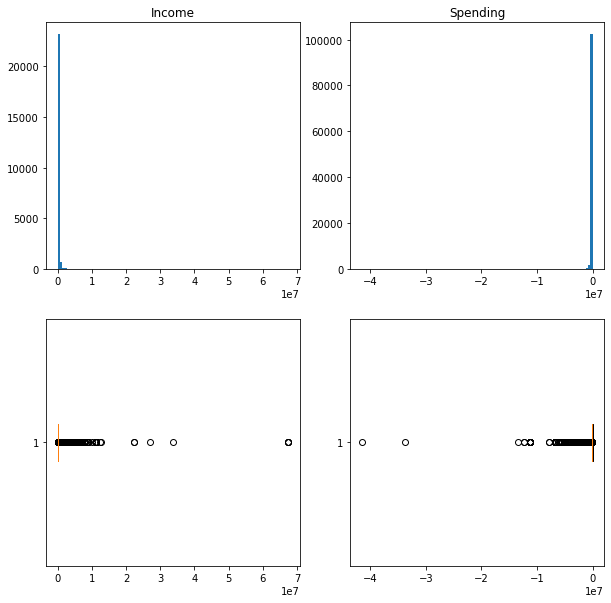

In [28]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize=(10,10))

ax[0,0].set_title('Income')
ax[0,1].set_title('Spending')

ax[0,0].hist(income, 100);
ax[1,0].boxplot(income, vert=False);

ax[0,1].hist(spending, 100);
ax[1,1].boxplot(spending, vert=False);

**Comment:** These histograms and boxplots illustrates the outliers of income and spendings. There we can see that for income we have positive values, starting from 0, and for spending is vice versa. 

### Visualization №2

In [29]:
df_v2 = transaction.groupby('code_description').code.count().sort_values(ascending = False).reset_index().head()
df_v2.head()

,code_description,code
0,Финансовые институты — снятие наличности автом...,27917
1,Финансовые институты — снятие наличности вручную,18684
2,"Звонки с использованием телефонов, считывающих...",18641
3,"Бакалейные магазины, супермаркеты",18467
4,Денежные переводы,11355


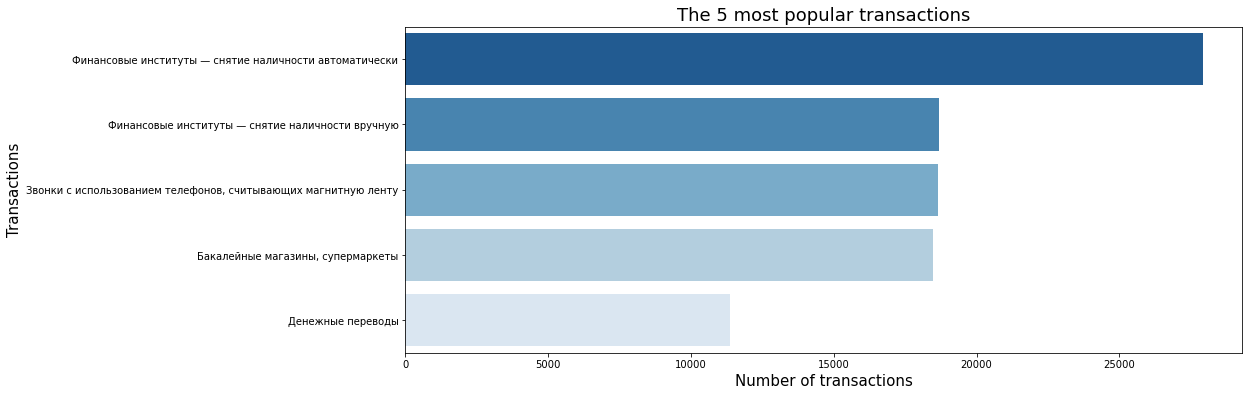

In [30]:
#Visualisation with horizontal bar plot using seaborn
fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = "code", y = "code_description", linewidth=1, palette = "Blues_r", data=df_v2)
plt.xlabel('Number of transactions', size = 15)
plt.ylabel('Transactions', size = 15)
plt.title('The 5 most popular transactions',  size = 18)
plt.show()

**Comment:** This horizontal barchart shows the 5 most popular transactions. To do this, we have grouped our transactions  by  code_description  and sorted by descending order. As we can see, the most popular transaction is "Финансовые институты — снятие наличности автоматически", which has almost 28000 transactions. Hence, we can conclude that people prefer automatic process of cash withdrawal. 

### Visualization №3

In [31]:
df_v3 = transaction.groupby('code_description').code.count().sort_values(ascending = False).reset_index().tail()
df_v3

,code_description,code
170,Нефть и нефтепродукты,1
171,Почтовые услуги — только правительство,1
172,Агенты и менеджеры по аренде недвижимости,1
173,Разнообразные издательства/печатное дело,1
174,"Генеральные подрядчики по вентиляции, теплосна...",1


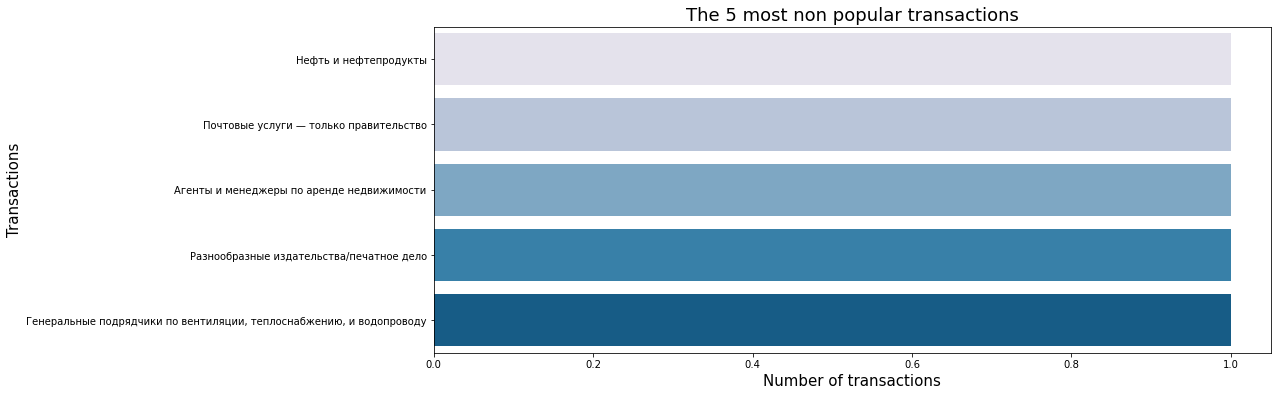

In [32]:
#Visualisation with horizontal bar plot using seaborn
fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = "code", y = "code_description", linewidth=1, palette = 'PuBu', data=df_v3)
plt.xlabel('Number of transactions', size = 15)
plt.ylabel('Transactions', size = 15)
plt.title('The 5 most non popular transactions',  size = 18)
plt.show()

### Visualization №4

In [33]:
popular_tranc = transaction[transaction.code_description=="Финансовые институты — снятие наличности автоматически"] 
popular_tranc.head()

,client_id,datetime,code,type,sum,target,type_description,code_description,Time,income,spending
0,96372458,421 06:33:15,6011,2010,-561478.94,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2020-11-27,0.00,-561478.94
1,24567813,377 17:20:40,6011,7010,67377.47,1.0,Взнос наличных через АТМ (в своем тер.банке),Финансовые институты — снятие наличности автом...,2020-10-14,67377.47,0.00
2,21717441,55 13:38:47,6011,2010,-44918.32,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2019-11-27,0.00,-44918.32
3,14331004,263 12:57:08,6011,2010,-3368873.66,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2020-06-22,0.00,-3368873.66
15,2444292,355 09:47:45,6011,2010,-65131.56,0.0,Выдача наличных в АТМ,Финансовые институты — снятие наличности автом...,2020-09-22,0.00,-65131.56


In [34]:
#Extract years from date by saving them into a new column 
popular_tranc['year'] = pd.DatetimeIndex(popular_tranc['Time']).year
popular_tranc['year']

<ipython-input-34-2338b3e029a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_tranc['year'] = pd.DatetimeIndex(popular_tranc['Time']).year


0         2020
1         2020
2         2019
3         2020
15        2020
          ... 
130012    2020
130016    2020
130027    2020
130028    2020
130032    2020
Name: year, Length: 27917, dtype: int64

In [35]:
df_v33 = popular_tranc.groupby("year")["code"].sum().reset_index()
df_v33 = popular_tranc.rename(columns = {"sum":"code"})
df_v33 = df_v33.sort_values(by = "year", ascending = True)

In [36]:
counts = df_v33.groupby(['year'])['client_id'].count()
counts

year
2019     5224
2020    22645
2021       48
Name: client_id, dtype: int64

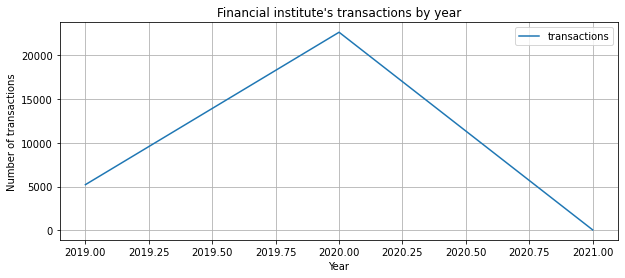

In [37]:
#Visualization of linear plot
plt.figure(figsize=(10,4))
plt.plot(counts.index, counts.values)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Number of transactions')
plt.title("Financial institute's transactions by year")
plt.legend(["transactions"])
plt.show()

**Comment:** This is a linear plot of Financial institute's transactions by year. As we can see, most of the transactions were done in 2020 and the minimum number of transactions were in 2021, because it's new year.

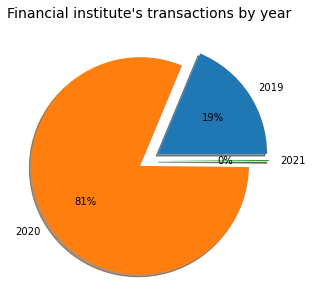

In [38]:
#Visualisation with pie chart using mathpotlib
fig, ax = plt.subplots(figsize=(10,5))
ax.pie(counts.values, labels = counts.index, explode = (0.1, 0.1, 0.1), autopct='%1.0f%%',shadow=True)
ax.set_title("Financial institute's transactions by year", size = 14)
plt.show()

**Comment:** The above pie chart shows the distribution of transactions in Financial institute, from previous illustration we can say that obviously 80%+ of transactions would be in 2020. And almost 0% of transactions in 2021.  

## 3. Feature engineering. Encodings, generating the features from date-time, sum and from other columns. 

### RFM Analysis

**Recency, frequency, monetary value (RFM) is a marketing analysis tool used to identify a firm's best clients based on the nature of their spending habits.**

In [39]:
rfm = transaction.groupby(by='client_id', as_index=False).Time.max()
rfm['Frequency'] =  transaction.groupby(by='client_id').Time.count().values
rfm = rfm.merge(transaction[transaction['sum']<0].groupby(by='client_id')['sum'].min(), how='left', on='client_id').rename(columns={'sum':'max_spending'})
rfm = rfm.merge(transaction[transaction['sum']<0].groupby(by='client_id')['sum'].max(), how='left', on='client_id').rename(columns={'sum':'min_spending'})
rfm = rfm.merge(transaction[transaction['sum']>0].groupby(by='client_id')['sum'].min(), how='left', on='client_id').rename(columns={'sum':'min_income'})
rfm = rfm.merge(transaction[transaction['sum']>0].groupby(by='client_id')['sum'].max(), how='left', on='client_id').rename(columns={'sum':'max_income'})
rfm = rfm.merge(transaction[transaction['sum']<0].groupby(by='client_id')['sum'].sum(), how='left', on='client_id').rename(columns={'sum':'spending'})
rfm = rfm.merge(transaction[transaction['sum']>0].groupby(by='client_id')['sum'].sum(), how='left', on='client_id').rename(columns={'sum':'income'})
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31


In [40]:
rfm.fillna(0, inplace=True)
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31


In [41]:
transaction[transaction['sum']<0].groupby(by='client_id')['sum'].min()

client_id
22899         -8759.07
27914         -2245.92
28753      -1392467.78
31385        -56147.89
38084       -224591.58
               ...    
99967537    -336887.37
99984336    -179673.26
99985917    -224591.58
99991245     -67377.47
99999680    -449183.15
Name: sum, Length: 8577, dtype: float64

In [42]:
transaction[transaction['sum']<0].groupby(by='client_id')['sum'].max()

client_id
22899        -1122.96
27914        -2245.92
28753        -3368.87
31385         -291.97
38084          -44.92
              ...    
99967537   -336887.37
99984336   -179673.26
99985917   -224591.58
99991245    -16574.86
99999680     -1527.22
Name: sum, Length: 8577, dtype: float64

In [43]:
range_tranc = pd.date_range(start=transaction.Time.min(),end = transaction.Time.max(), periods = 4).tolist()
range_tranc

[Timestamp('2019-10-03 00:00:00'),
 Timestamp('2020-03-03 00:00:00'),
 Timestamp('2020-08-02 00:00:00'),
 Timestamp('2021-01-01 00:00:00')]

In [44]:
rfm['recent_range'] = pd.cut(rfm.Time.values, 
                     range_tranc, 
                     right=False, 
                     labels=['давние клиенты', 
                             'относительно недавние клиенты', 
                             'недавние клиенты'])

In [45]:
rfm.groupby(by='recent_range').Time.count()

recent_range
давние клиенты                    205
относительно недавние клиенты     601
недавние клиенты                 7566
Name: Time, dtype: int64

<AxesSubplot:xlabel='Frequency'>

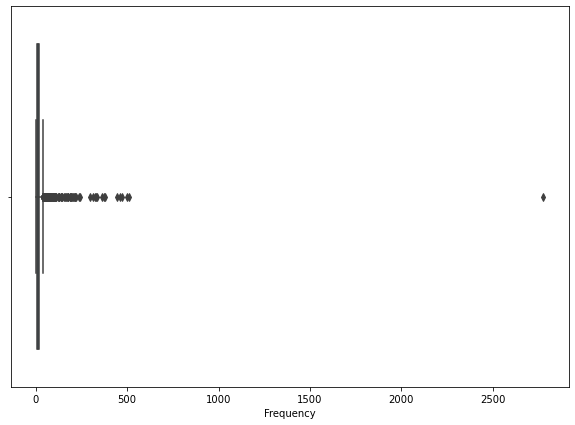

In [46]:
plt.figure(figsize=(10,7))
sns.boxplot(data=rfm, x=rfm.Frequency)

In [47]:
Q3 = np.percentile(rfm.Frequency, 75)
Q1 = np.percentile(rfm.Frequency, 25)
IQR = Q3-Q1
pos_out = Q3 + 1.5*IQR
pos_out

40.0

In [48]:
r = math.ceil(pos_out/3)
conditions = [
    (rfm.Frequency < r),
    (rfm.Frequency >= r) & (rfm.Frequency < 2*r),
    (rfm.Frequency >= 2*r) & (rfm.Frequency <= pos_out) | (rfm.Frequency > pos_out)
    ]

values = ['делает тран очень редко', 
          'делает тран нечасто',
          'делает тран часто']

rfm['frequency_range'] = np.select(conditions, values)

In [49]:
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81,недавние клиенты,делает тран очень редко
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05,относительно недавние клиенты,делает тран очень редко
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73,недавние клиенты,делает тран очень редко
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57,недавние клиенты,делает тран очень редко
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31,недавние клиенты,делает тран нечасто


In [50]:
rfm.groupby(by='frequency_range').Frequency.count()

frequency_range
делает тран нечасто        2440
делает тран очень редко    5241
делает тран часто           975
Name: Frequency, dtype: int64

<AxesSubplot:xlabel='spending'>

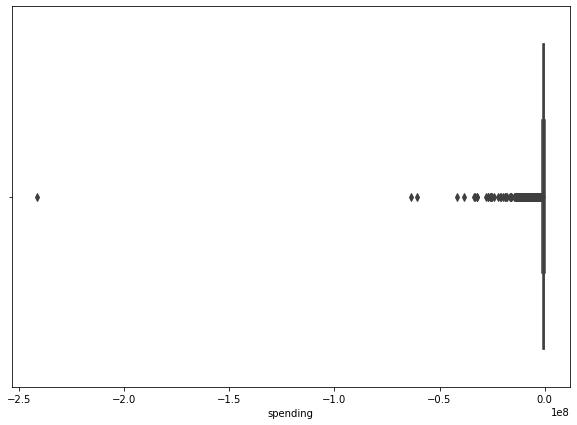

In [51]:
plt.figure(figsize=(10,7))
sns.boxplot(data=rfm, x=rfm.spending)

In [52]:
Q3 = np.percentile(rfm.spending, 75)
Q1 = np.percentile(rfm.spending, 25)
IQR = Q3 - Q1
neg_out = Q1 - 1.5*IQR
neg_out

-1442779.2262499998

In [53]:
r = math.ceil(neg_out/3)
conditions = [
    (rfm.spending > r),
    (rfm.spending <= r) & (rfm.spending > 2*r),
    (rfm.spending <= 2*r) & (rfm.spending >= neg_out) | (rfm.spending < neg_out)
    ]

values = ['минус маленькая сумма', 
          'минус средняя сумма',
          'минус большая сумма']

rfm['minus_amount'] = np.select(conditions, values)

In [54]:
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range,minus_amount
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81,недавние клиенты,делает тран очень редко,минус маленькая сумма
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05,относительно недавние клиенты,делает тран очень редко,минус маленькая сумма
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73,недавние клиенты,делает тран очень редко,минус большая сумма
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57,недавние клиенты,делает тран очень редко,минус маленькая сумма
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31,недавние клиенты,делает тран нечасто,минус большая сумма


In [55]:
rfm.minus_amount.value_counts()

минус маленькая сумма    5904
минус большая сумма      1420
минус средняя сумма      1332
Name: minus_amount, dtype: int64

<AxesSubplot:xlabel='income'>

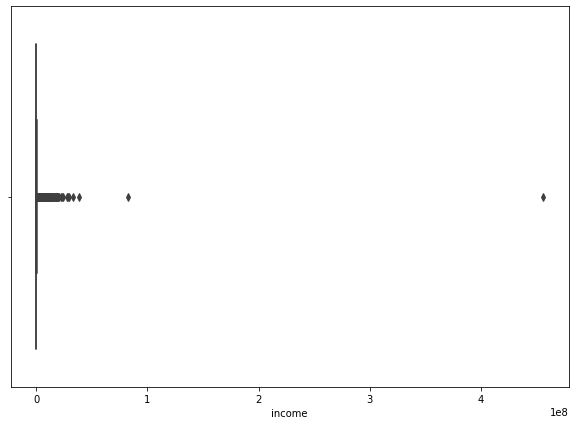

In [56]:
plt.figure(figsize=(10,7))
sns.boxplot(data=rfm, x=rfm.income)

In [57]:
Q3 = np.percentile(rfm.income, 75)
Q1 = np.percentile(rfm.income, 25)
IQR = Q3 - Q1
pos_out = Q3 + 1.5*IQR
pos_out

564988.2125

In [58]:
r = math.ceil(pos_out/3)
conditions = [
    (rfm.income < r),
    (rfm.income >= r) & (rfm.income < 2*r),
    (rfm.income >= 2*r) & (rfm.income <= pos_out) | (rfm.income > pos_out)
    ]

values = ['plus маленькая сумма', 
          'plus средняя сумма',
          'plus большая сумма']

rfm['plus_amount'] = np.select(conditions, values)

In [59]:
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range,minus_amount,plus_amount
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81,недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05,относительно недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73,недавние клиенты,делает тран очень редко,минус большая сумма,plus большая сумма
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57,недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31,недавние клиенты,делает тран нечасто,минус большая сумма,plus большая сумма


In [60]:
rfm.plus_amount.value_counts()

plus маленькая сумма    6243
plus большая сумма      1638
plus средняя сумма       775
Name: plus_amount, dtype: int64

In [61]:
re = {'давние клиенты':1, 
      'относительно недавние клиенты':2, 
      'недавние клиенты':3}

fr = {'делает тран очень редко':1, 
      'делает тран нечасто':2,
      'делает тран часто':3}

mi = {'минус маленькая сумма':3, 
      'минус средняя сумма':2,
      'минус большая сумма':1}

pl = {'plus маленькая сумма':1, 
      'plus средняя сумма':2,
      'plus большая сумма':3}

rfm['re_range'] = rfm.recent_range.map(re)
rfm['fre_range'] = rfm.frequency_range.map(fr)
rfm['min_amount'] = rfm.minus_amount.map(mi)
rfm['pl_amount'] = rfm.plus_amount.map(pl)
rfm.head()

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range,minus_amount,plus_amount,re_range,fre_range,min_amount,pl_amount
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81,недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма,3,1,3,1
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05,относительно недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма,2,1,3,1
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73,недавние клиенты,делает тран очень редко,минус большая сумма,plus большая сумма,3,1,1,3
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57,недавние клиенты,делает тран очень редко,минус маленькая сумма,plus маленькая сумма,3,1,3,1
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31,недавние клиенты,делает тран нечасто,минус большая сумма,plus большая сумма,3,2,1,3


In [62]:
# the worst clients (1111)
rfm[(rfm.re_range == 1) & (rfm.fre_range==1) & (rfm.min_amount==1) & (rfm.pl_amount==1)]

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range,minus_amount,plus_amount,re_range,fre_range,min_amount,pl_amount
158,1798485,2019-11-15,7,-3368873.66,-5614.79,0.0,0.0,-3635531.24,0.0,давние клиенты,делает тран очень редко,минус большая сумма,plus маленькая сумма,1,1,1,1
2896,34179937,2020-01-29,2,-1684436.83,-26411.97,0.0,0.0,-1710848.80,0.0,давние клиенты,делает тран очень редко,минус большая сумма,plus маленькая сумма,1,1,1,1
6955,80698386,2019-11-03,2,-761365.45,-224591.58,0.0,0.0,-985957.03,0.0,давние клиенты,делает тран очень редко,минус большая сумма,plus маленькая сумма,1,1,1,1
7596,88062408,2020-01-17,1,-1122957.89,-1122957.89,0.0,0.0,-1122957.89,0.0,давние клиенты,делает тран очень редко,минус большая сумма,plus маленькая сумма,1,1,1,1


In [63]:
# the best clients (3333)
rfm[(rfm.re_range == 3) & (rfm.fre_range==3) & (rfm.min_amount==3) & (rfm.pl_amount==3)]

,client_id,Time,Frequency,max_spending,min_spending,min_income,max_income,spending,income,recent_range,frequency_range,minus_amount,plus_amount,re_range,fre_range,min_amount,pl_amount
557,6506523,2020-12-25,53,-52734.10,-1122.96,875.91,898366.31,-247463.08,2883216.82,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
675,7927145,2020-12-31,39,-404264.84,-314.43,269.51,197640.59,-474791.12,523073.80,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
817,9605096,2020-12-28,30,-67377.47,-673.77,2245.92,774840.94,-270178.07,781017.21,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
845,9978856,2020-12-31,29,-29196.91,-449.18,112295.79,628856.42,-172620.43,1327336.23,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
921,10909988,2020-12-01,35,-67152.88,-673.77,224591.58,449183.15,-333835.17,673774.73,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
932,11089937,2020-12-27,28,-67377.47,-1122.96,11229.58,190902.84,-290668.21,487363.72,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
1144,13587967,2020-10-30,29,-89836.63,-1179.11,673774.73,673774.73,-469823.59,673774.73,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
1161,13775509,2020-12-18,29,-51633.60,-154.97,11229.58,381805.68,-193661.28,460412.74,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
1542,18139443,2020-12-25,28,-112295.79,-235.82,56147.89,669507.49,-351097.29,725655.38,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3
1641,19409011,2020-12-05,33,-40426.48,-473.66,2270.85,449183.15,-281114.97,451454.00,недавние клиенты,делает тран часто,минус маленькая сумма,plus большая сумма,3,3,3,3


### 4. Unsupervised learning. Do the Cluster analysis. Segment the customers. K-means, Hierarchical Clustering. With different metrics, linkages. Visualize the clusters etc. Look for the optimal number of the clusters

### Find the similarity of two sentences using the cosine distance

In [64]:
pip install pymystem3

Note: you may need to restart the kernel to use updated packages.


In [65]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from pymystem3 import Mystem

import string
from string import punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mereyorazaly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
# Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

In [67]:
# Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [68]:
_near = []
for i in transaction.code_description.unique():
    _near.append(preprocess_text(i))
    
vectorizer = CountVectorizer().fit_transform(_near)
vectors = vectorizer.toarray()
vector_size = len(vectors)
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [69]:
def cosine_sim_vectors(vec1, vec2):
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]

In [70]:
def near_word(j, vector_size):
    arr_i = []
    arr_v = []
    for i in range(vector_size):
        result = cosine_sim_vectors(vectors[j], vectors[i])
        
        if(result<0.99 and result>0.1):
            arr_i.append(i)
            arr_v.append(result)
    ans = []
    ans.append({'idx': max_index(arr_i, arr_v), 'value':max(arr_v)})
    return ans

In [71]:
def max_index(x, y):
    _max = max(y)
    _max_index = -1
    for i in range(len(y)):
        if(_max == y[i]):
            _max_index = i
    return x[_max_index]

In [72]:
# Similar to the first sentence is the fourth
print(near_word(0, vector_size))
print(_near[0])
print(_near[3])

[{'idx': 3, 'value': 0.7999999999999999}]
финансовый институт  —  снятие наличность автоматически
финансовый институт  —  снятие наличность вручную


In [73]:
print(near_word(1, vector_size))
print(_near[1])
print(_near[79])

[{'idx': 79, 'value': 0.18257418583505539}]
звонок использование телефон считывать магнитный лента
телекоммуникационный оборудование включая продажа телефон


### Classification

In [74]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import matplotlib.pyplot as plt

In [75]:
near = transaction.code_description

In [76]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(near).todense()

pca = PCA(n_components=2).fit(X) # N dimension to 2D
data2D = pca.transform(X)
print(X.shape)
print(data2D.shape)

(129917, 477)
(129917, 2)


In [77]:
df = pd.DataFrame()

# 0 - Финансы
# 1 - Телефон
# 2 - Магазин
# 3 - Другое

df['_class'] = ['0' if 'инанс' in i else '1' if 'агазин' in i else '2' if 'телефон' in i else '3' for i in near]

In [78]:
df['X'] = data2D[:,0]
df['Y'] = data2D[:,1]

df.head(10)

,_class,X,Y
0,0,0.664476,-0.004580
1,0,0.664476,-0.004580
2,0,0.664476,-0.004580
3,0,0.664476,-0.004580
4,2,-0.473938,0.746770
5,1,-0.513737,-0.662951
6,0,0.586362,-0.003545
7,2,-0.473938,0.746770
8,2,-0.473938,0.746770
9,1,-0.221441,-0.050276


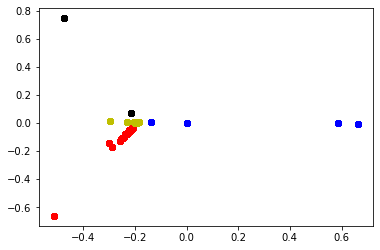

In [79]:
df0 = df[df._class == '0']
df1 = df[df._class == '1']
df2 = df[df._class == '2']
df3 = df[df._class == '3']

plt.scatter(df0['X'], df0['Y'], c = 'b')
plt.scatter(df1['X'], df1['Y'], c = 'r')
plt.scatter(df2['X'], df2['Y'], c = 'black')
plt.scatter(df3['X'], df3['Y'], c = 'y')
plt.show() 

In [80]:
# and Also with unqiue code_description
X = pipeline.fit_transform(_near).todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
print(X.shape)
print(data2D.shape)

(175, 415)
(175, 2)


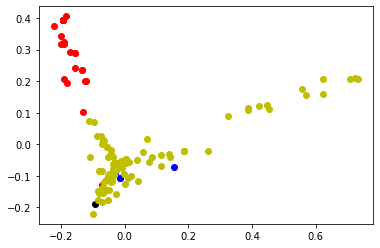

In [81]:
df = pd.DataFrame()
df['_class'] = ['0' if 'инанс' in i else '1' if 'агазин' in i else '2' if 'телефон' in i else '3' for i in _near]

df['X'] = data2D[:,0]
df['Y'] = data2D[:,1]

df0 = df[df._class == '0']
df1 = df[df._class == '1']
df2 = df[df._class == '2']
df3 = df[df._class == '3']

plt.scatter(df0['X'], df0['Y'], c = 'b')
plt.scatter(df1['X'], df1['Y'], c = 'r')
plt.scatter(df2['X'], df2['Y'], c = 'black')
plt.scatter(df3['X'], df3['Y'], c = 'y')
plt.show() 

### Hierarchical Clustering with different linkages

In [82]:
rfm.dropna(inplace=True)

In [83]:
data = rfm.iloc[:,-4:].sample(n = 10, random_state=2022)
data.index = [rfm[rfm.index==i].client_id.values[0] for i in data.index]

In [84]:
data

,re_range,fre_range,min_amount,pl_amount
84422977,3,1,2,1
370258,3,3,1,3
42235367,3,1,3,1
87450603,3,2,2,2
87451106,3,3,1,3
91582559,3,3,1,1
62408586,3,2,3,3
45338523,3,2,3,1
35759014,3,2,3,1
58163794,3,2,1,1


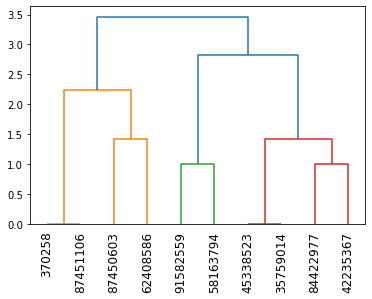

In [85]:
import scipy.cluster.hierarchy as model
dend_max = model.dendrogram(model.linkage(data.iloc[:,:4], method='complete'), labels=data.index, leaf_rotation=90)

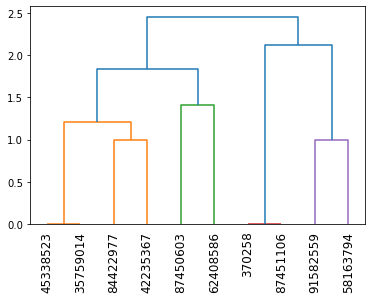

In [86]:
import scipy.cluster.hierarchy as model
dend_max = model.dendrogram(model.linkage(data.iloc[:,:4], method='average'), labels=data.index, leaf_rotation=90)

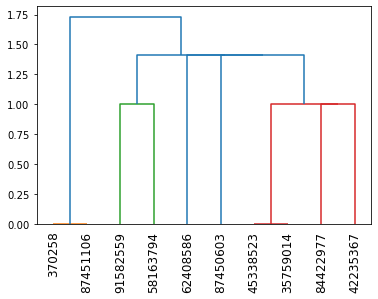

In [87]:
import scipy.cluster.hierarchy as model
dend_max = model.dendrogram(model.linkage(data.iloc[:,:4], method='single'), labels=data.index, leaf_rotation=90)

### K Nearest Neighbours

In [88]:
rfm = rfm.merge(transaction.groupby(by='client_id').agg(pd.Series.mode), how='left', on='client_id')
rfm.head()

,client_id,Time_x,Frequency,max_spending,min_spending,min_income,max_income,spending_x,income_x,recent_range,...,min_amount,pl_amount,code,type,sum,target,code_description,Time_y,income_y,spending_y
0,22899,2020-12-17,9,-8759.07,-1122.96,17967.33,44918.32,-34497.27,85344.81,недавние клиенты,...,3,1,6011,4010,-8759.07,1.0,Финансовые институты — снятие наличности автом...,"[2019-12-03 00:00:00, 2019-12-08 00:00:00, 202...",0.0,0.0
1,27914,2020-07-21,4,-2245.92,-2245.92,11229.58,67377.47,-4491.84,78607.05,относительно недавние клиенты,...,3,1,4814,1030,-2245.92,1.0,"Звонки с использованием телефонов, считывающих...","[2020-02-21 00:00:00, 2020-03-18 00:00:00, 202...",0.0,"[-2245.92, 0.0]"
2,28753,2020-12-09,13,-1392467.78,-3368.87,673774.73,673774.73,-3263575.02,673774.73,недавние клиенты,...,1,3,4814,1010,-4491.83,0.0,"Звонки с использованием телефонов, считывающих...","[2020-01-02 00:00:00, 2020-01-15 00:00:00, 202...",0.0,-4491.83
3,31385,2020-08-12,13,-56147.89,-291.97,4491.83,33688.74,-121705.95,38180.57,недавние клиенты,...,3,1,"[4814, 5411]",1030,"[-56147.89, -22459.16, -12801.72, -8570.19, -8...",0.0,"[Бакалейные магазины, супермаркеты, Звонки с и...",2020-03-23 00:00:00,0.0,0.0
4,38084,2020-12-05,26,-224591.58,-44.92,22459.16,988202.94,-1058318.65,1751814.31,недавние клиенты,...,1,3,6011,1010,-2245.92,0.0,Финансовые институты — снятие наличности автом...,"[2020-02-21 00:00:00, 2020-03-23 00:00:00]",0.0,0.0


In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rfm.loc[:,'re_range':'pl_amount'], rfm.target, test_size=0.25, random_state=2022)

In [90]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [91]:
result = pd.DataFrame(data = np.array(y_test), columns=["Class"])
result["predicted_class"] = clf.predict(X_test)
result.head()

,Class,predicted_class
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,0.0


In [92]:
training_accuracy = [] 
test_accuracy = []
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(X_train, y_train)
    # record training set accuracy 
    training_accuracy.append(clf.score(X_train, y_train)) 
    # record generalization accuracy 
    test_accuracy.append(clf.score(X_test, y_test))

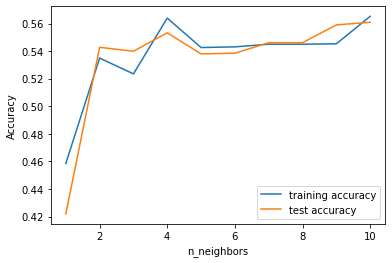

In [93]:
plt.plot(neighbors_settings, training_accuracy, label="training accuracy") 
plt.plot(neighbors_settings, test_accuracy, label="test accuracy") 
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

**Comment:** There we can see underfitting between train and test accuracies. Hence, it is a non normal model. For generalization of model we need to increase model complexity or remove noise from the data. 

## 5. Analyzing the results

**Using RFM principle you can see that we have 3 types of clients and separate our clients into 2 parts (best/worst). Using this RFM you can build the model that can identify the gender of people, because Males and Females makes different transactions, for example, females like to go shopping. That' why the spending money of genders is different. Due to imbalanced dataset with missing values, we have models that are not good enough.**

## 6. Conclusion

**We have used different methods to explore and get informaiton about transactions in bank account. With Explarotatory Data Analysis (EDA) we have visualized the popular/non popular transactions, get the picture of the popular Financial institute transaction. Using Recency, frequency, monetary value (RFM) we have identified the best & worst clients. With classification we have filtered the data based on categorical changes.**